In [94]:
import os
import numpy as np
import matplotlib.pyplot as plt

path = "/content/drive/MyDrive/Academics/110-1 人工智慧於醫療應用與服務/HW1 EKG Detection/EKG_seg/"
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/Academics/110-1 人工智慧於醫療應用與服務/HW1 EKG Detection/EKG_seg'

In [95]:
fname = "img.png"
label = "label.png"
img_size = (480, 480)
num_classes = 2
batch_size = 4
train_ratio = 0.9
val_ratio = 0.1

input_img_paths = sorted(
    [
        os.path.join(path, f"{dir}/{fname}")
        for dir in os.listdir(path)
        if not dir.endswith(".h5")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(path, f"{dir}/{label}")
        for dir in os.listdir(path)
        if not dir.endswith(".h5")
    ]
)

sample_size = len(input_img_paths)
print("Number of samples:", sample_size)

Number of samples: 230


In [96]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import math
import cv2

X_INIT_RATIO = 0.08 # 0.08, 1337/1448 = 0.92
Y_INIT_RATIO = 0.36 # 0.36, 951/1024 = 0.93
X_END_RATIO = 0.92
Y_END_RATIO = 0.93
WHITE = 255

class EkgSegmentation(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return math.ceil(len(self.target_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        if i + self.batch_size > len(self.input_img_paths):  # last batch size < batch_size
            batch_input_img_paths = self.input_img_paths[i : ]
            batch_target_img_paths = self.target_img_paths[i : ]
            self.batch_size = len(self.target_img_paths[i : ])
        else:
            batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
            batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, color_mode="grayscale")
            img = np.array(img)

            # do preprocessing
            img = self.clean_input_img(img)

            img = cv2.resize(img, self.img_size)
            x[j] = np.expand_dims(img, 2)
        y = np.zeros((self.batch_size,) + self.img_size + (2,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")  # red: 38, green: 75, black: 0
            img = np.array(img)
            y[j, :, :, 0] = np.where(img == 75, 1, 0)  # green
            y[j, :, :, 1] = np.where(img == 38, 1, 0)  # red

        return x, y

    def clean_input_img(self, img: np.ndarray):
        height = img.shape[0]
        width = img.shape[1]

        img[: int(Y_INIT_RATIO * height), :] = WHITE
        img[int(Y_END_RATIO * height):, :] = WHITE
        img[:, : int(X_INIT_RATIO * width)] = WHITE
        img[:, int(X_END_RATIO * width):] = WHITE

        threshold = 127
        _, img = cv2.threshold(img, threshold, WHITE, cv2.THRESH_BINARY)

        return img


In [97]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
# model.summary()

In [98]:
import random

# Split our img paths into a training and a validation set
val_samples = int(sample_size * val_ratio)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = EkgSegmentation(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = EkgSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Inference

In [99]:
from tensorflow import keras
model = keras.models.load_model("res.480_batch.4_thres.127_epoch.50.h5")

# Generate predictions for all images in the validation set
val_gen = EkgSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

In [100]:
size = (480, 340)

def show_ground_truth(file: str):
    ground = cv2.imread(file)
    ground = cv2.cvtColor(ground, cv2.COLOR_BGR2RGB)
    ground = cv2.resize(ground, size)
    plt.imshow(ground)
    plt.show()

def show_pred(pred: np.ndarray, i: int):
    colored_mask = np.zeros(img_size + (3,), dtype=np.uint8)
    colored_mask[:, :, 1] = np.where(pred[i, :, :, 0] > 0.9, 200, 0)
    colored_mask[:, :, 0] = np.where(pred[i, :, :, 1] > 0.9, 200, 0)
    colored_mask = cv2.resize(colored_mask, size)
    plt.imshow(colored_mask)
    plt.show()

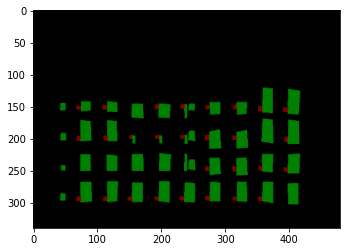

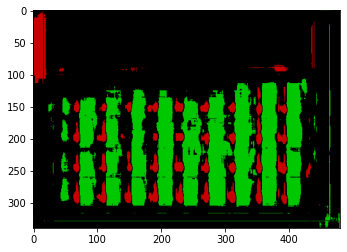

In [105]:
import random
i = random.randint(0, len(val_target_img_paths))
show_ground_truth(val_target_img_paths[i])
show_pred(val_preds, i)

## Training

In [ ]:
# Configure the model for training.
model.compile(optimizer=optimizers.Adam(lr = 1e-3), loss="binary_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("ekg_segmentation.h5", monitor='val_loss', save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

In [ ]:
# Generate predictions for all images in the validation set

val_gen = EkgSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)